In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os


In [4]:
#similar images
image1_path = './dataset-dev/plates/GB.292020.A-009.tif'
image2_path = './Users/mac/Desktop/tbi/Semester-Project/data/images/GB.191319946.A-006.tif'
image3_path = './Users/mac/Desktop/tbi/Semester-Project/data/images/GB.425576.A-003.tif'
image4_path = '/Users/mac/Desktop/tbi/Semester-Project/data/images/GB.512507.A-003.tif'

In [5]:


def is_contour_inside(contour1, contour2):
    x1, y1, w1, h1 = cv2.boundingRect(contour1)  # inside
    x2, y2, w2, h2 = cv2.boundingRect(contour2)  # outside
    if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
        return True

def bounding_box_to_contour(box):
    x, y, w, h = box
    contour = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    return contour

In [5]:
gb = []
for i in os.listdir('./preprocessed_imgs/'):
    if i.__contains__('GB'):
        
        gb.append(i)
gb

['processed_GB.496204.A-005.png',
 'processed_GB.366323.A-006.png',
 'processed_GB.152368.A-028.png',
 'processed_GB.191223716.A-015.png',
 'processed_GB.152368.A-014.png',
 'processed_GB.548701.A-007.png',
 'processed_GB.128645.A-007.png',
 'processed_GB.174504.A-005.png',
 'processed_GB.334584.A-058.png',
 'processed_GB.516128.A-008.png',
 'processed_GB.544722.A-031.png',
 'processed_GB.544722.A-025.png',
 'processed_GB.287257.A-006.png',
 'processed_GB.400571.A-004.png',
 'processed_GB.505944.A-008.png',
 'processed_GB.180631.A-003.png',
 'processed_GB.294106.A-015.png',
 'processed_GB.202869.A-004.png',
 'processed_GB.357609.A-004.png',
 'processed_GB.229918.A-005.png',
 'processed_GB.191506686.A-016.png',
 'processed_GB.191424817.A-004.png',
 'processed_GB.208112.A-003.png',
 'processed_GB.411884.A-023.png',
 'processed_GB.191402180.A-005.png',
 'processed_GB.323831.A-005.png',
 'processed_GB.163636.A-008.png',
 'processed_GB.323831.A-004.png',
 'processed_GB.191402180.A-004.png',

In [5]:

from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew


def deskew(_img):
    image = _img.copy()
    
    # Check if the image is already grayscale
    if len(image.shape) == 2:  # Grayscale image
        grayscale = image
    else:  # RGB image
        grayscale = rgb2gray(image)
    
    angle = determine_skew(grayscale)
    if angle in range(-10,10) and angle != 0.0:
        rotated = rotate(image, -angle, resize=True) * 255
        print('Rotated')
    else: 
        rotated = image
    return rotated.astype(np.uint8)

In [187]:
def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 250, apertureSize=3,L2gradient=True)
    kernel = np.ones((5, 5), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=2)
    return img_dilate

#first phase of segmentation to remove outer border present in images
def first_phase(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process(img_copy)
    #processed_img = deskew(processed_img)
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 3000] #filter out small contours
    areas = []
    original_size = img_copy.shape
    #print(len(filter_contours))
    #draw contours as masks
    for ct in filter_contours:
        

SyntaxError: unexpected EOF while parsing (1317245683.py, line 22)

In [9]:
def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 250, apertureSize=3,L2gradient=True)
    kernel = np.ones((5, 5), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=2)
    return img_dilate

#first phase of segmentation to remove outer border present in images
def first_phase(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process(img_copy)
    #processed_img = deskew(processed_img)
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 3000] #filter out small contours
    areas = []
    original_size = img_copy.shape
    #print(len(filter_contours))
    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        areas.append(w*h)
        
    #print(len(areas))
    biggest = filter_contours[areas.index(max(areas))]
    #print(cv2.arcLength(biggest, True))
    #print(cv2.arcLength(biggest, False))
    
    epsilon = 0.02 * cv2.arcLength(biggest, False)
    approx = cv2.approxPolyDP(biggest, epsilon, False)
    #cv2.drawContours(img_copy, [approx], -1, (0, 0, 255), 2)
    #cv2.polylines(img_copy, [approx], isClosed=False, color=(0, 255, 0), thickness=2)
    hull =cv2.convexHull(biggest)
    #bounding box of hull
    x, y, w, h = cv2.boundingRect(hull)
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
    #print(hull)
    #cv2.drawContours(img_copy, [hull], -1, (0, 0, 255), 2)
    #k = cv2.isContourConvex(biggest)
    #print(k)
    #cv2.drawContours(img_copy,[biggest], -1, (0, 0, 255), 2)
    '''
    oldx, oldy, oldw, oldh = cv2.boundingRect(biggest)
    #paddingx= oldw* 1//30
    #paddingy= oldh* 1//20
    paddingx= 50
    paddingy= 50
    new_w = oldw - paddingx
    new_h = oldh - paddingy
    new_x = oldx + paddingx
    new_y = oldy + paddingy
    biggest = img_copy[new_y:oldy+new_h, new_x:oldx+new_w]
    # Create a white background image with the same size as the original
    white_background = np.ones((original_size[0], original_size[1], 3), dtype=np.uint8) * 255
    
    # Calculate the center position
    #center_x = (original_size[1] - biggest.shape[1]) // 2
    #center_y = (original_size[0] - biggest.shape[0]) // 2
    
    # Place the ROI in the center of the white background
    white_background[new_y:new_y+biggest.shape[0], new_x:new_x+biggest.shape[1]] = biggest'''
    #for ct in filter_contours:
        #x, y, w, h = cv2.boundingRect(ct)
        #cv2.rectangle(img_copy, (x+70, y+70), (x + w-50, y + h-50), (0, 0, 255), 2)
    return img_copy, filter_contours,hull
        
    
def second_phase(img_first_phase,img_original):
    img_copy = np.copy(img_first_phase)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(process(img_copy), connectivity=4, ltype=cv2.CV_32S)
    contours = []
    #area = img_copy.shape[0] * img_copy.shape[1]
    for i in range(1, num_labels):
        x, y, w, h, _ = stats[i]
        box = (x, y, w, h)
        contour = bounding_box_to_contour(box)
        contours.append(contour)
        
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 3000]
    # get rid of small contours
    sorted_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)
    
        
    for idx,contour in enumerate(sorted_contours):
        if idx == 0:
            #x, y, w, h = cv2.boundingRect(contour)
            #cv2.rectangle(img_original, (x, y), (x + w, y + h), (0, 0, 255), 2)
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img_copy,[box],0,(0,0,255),2)   
        else:
            #x, y, w, h = cv2.boundingRect(contour)
            res = False
            for i in range(idx):
                if is_contour_inside(contour, sorted_contours[i]):
                    res = True
                    break
            if not res: #the contour is not inside any of the previous contours
                #x, y, w, h = cv2.boundingRect(contour)
                #cv2.rectangle(img_original, (x, y), (x + w, y + h), (0, 0, 255), 2)
                rect = cv2.minAreaRect(contour)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                cv2.drawContours(img_copy,[box],0,(0,0,255),2)
                


    return img_copy, sorted_contours,img_original
    
    




In [99]:
for i in gb[0:10]:
    
    img_copy,_,_ = first_phase('./dataset-dev/plates/'+i)
    print(i)
    cv2.imshow("phase 1", img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #segmented, contours,_ = second_phase(figure,img_copy)
    #cv2.imshow("phase 2", segmented)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

GB.112704.A-011.tif
GB.426870.A-007.tif
GB.220420.A-010.tif
GB.544722.A-035.tif
GB.544722.A-021.tif
GB.411884.A-027.tif
GB.411884.A-033.tif
GB.411963.A-008.tif
GB.496119.A-009.tif
GB.272628.A-015.tif


In [71]:

def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 250, apertureSize=3,L2gradient=True)
    kernel = np.ones((5, 5), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=2)
    return img_dilate.astype(np.uint8)


# Load the image
image = cv2.imread('./dataset-dev/plates_png/GB.112704.A-011.png', cv2.IMREAD_GRAYSCALE)
processed_img = process(image)
# Apply edge detection using Canny
#edges = cv2.Canny(processed_img, 50, 150, apertureSize=7,L2gradient=True)

# Detect lines using the probabilistic Hough Line Transform
lines = cv2.HoughLinesP(processed_img, rho=0.5, theta=np.pi / 180, threshold=25, minLineLength=50, maxLineGap=100)

# Create a copy of the original image to draw on
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw the detected lines on the output image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
cv2.imshow('Detected Lines', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [6]:
import cv2
import numpy as np
import math

def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 1)
    kernel = np.ones((9, 9), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=4)
    return img_dilate

def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def closest2_contours(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process(img_copy)
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    # Filter out small contours
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 3000]
    areas = []
    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        areas.append(w * h)
    #areas = [cv2.contourArea(ct) for ct in filter_contours]
    
    # Find the largest contour by area
    largest_contour_index = areas.index(max(areas))
    
    largest_contour = filter_contours[largest_contour_index]
    
    # Get the bounding rectangle for the largest contour
    x_largest, y_largest, w_largest, h_largest = cv2.boundingRect(largest_contour)
    top_left_largest = (x_largest, y_largest)
    top_right_largest = (x_largest + w_largest, y_largest)
    
    # Find the closest contour to the largest contour based on top-left and top-right corners
    min_distance = float('inf')
    second_closest_contour = None
    
    for i,ct in enumerate(filter_contours):
        if i==largest_contour_index:  # Skip the largest contour itself
            continue
        
        x, y, w, h = cv2.boundingRect(ct)
        top_left = (x, y)
        top_right = (x + w, y)
        
        # Calculate average distance based on top-left and top-right corners
        distance = (euclidean_distance(top_left_largest, top_left) + 
                    euclidean_distance(top_right_largest, top_right)) / 2
        
        # Check if this is the second closest contour
        if distance < min_distance:
            min_distance = distance
            second_closest_contour = ct
    
    # Draw rectangles around the largest and second closest contours
    cv2.rectangle(img_copy, (x_largest, y_largest), (x_largest + w_largest, y_largest + h_largest), (0, 0, 255), 2)
    if second_closest_contour is not None:
        x, y, w, h = cv2.boundingRect(second_closest_contour)
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Different color for the second closest
    
    return img_copy, [largest_contour, second_closest_contour]




In [7]:
for i in gb[0:13]:
    
    img_copy,_ = closest2_contours(data_path+i)
    print(i)
    cv2.imshow("phase 1", img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #segmented, contours,_ = second_phase(figure,img_copy)
    #cv2.imshow("phase 2", segmented)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

NameError: name 'data_path' is not defined

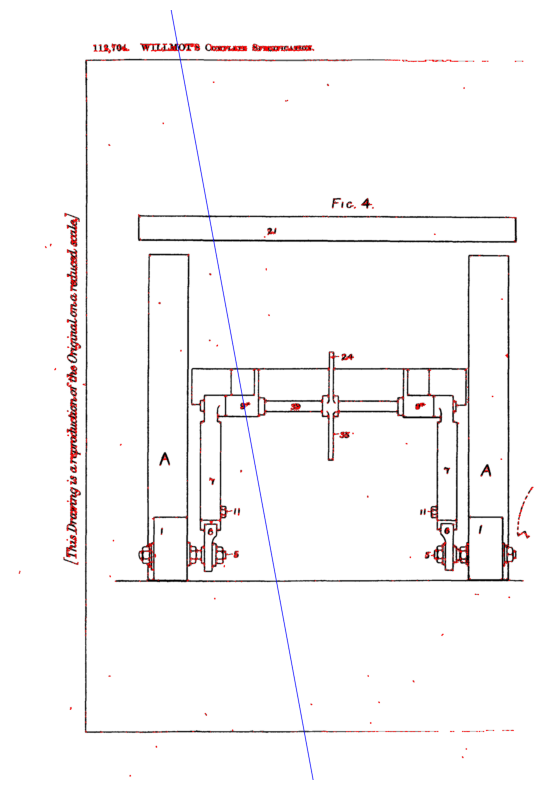

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/mnt/data/image.png', cv2.IMREAD_GRAYSCALE)

# Blur the image to reduce noise
image = cv2.GaussianBlur(image, (5, 5), 0)

# Crop the image (optional, based on your initial code)
image = image[100:-100, :]

# Convert the image to float32
gray = np.float32(image)

# Apply Harris corner detection
corner_response = cv2.cornerHarris(src=gray, blockSize=2, ksize=7, k=0.07)

# Dilate the corner response image to make the corners more visible
corner_response = cv2.dilate(corner_response, None)

# Threshold for optimal value
threshold = 0.001 * corner_response.max()

# Find the coordinates of the corner points that exceed the threshold
coordinates = np.argwhere(corner_response > threshold)
coordinates = np.fliplr(coordinates)  # Switch from (y, x) to (x, y) format

# Create a copy of the original image to display corners
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Mark the detected corners in red
output_image[corner_response > threshold] = [0, 0, 255]

# Fit a line through the detected corner points (x, y)
if len(coordinates) > 0:
    [vx, vy, x, y] = cv2.fitLine(coordinates, cv2.DIST_L2, 0, 0.01, 0.01)
    
    # Calculate two points to draw the line (extend it)
    lefty = int((-x * vy / vx) + y)
    righty = int(((output_image.shape[1] - x) * vy / vx) + y)
    
    # Draw the fitted line in blue
    cv2.line(output_image, (output_image.shape[1] - 1, righty), (0, lefty), (255, 0, 0), 2)

# Convert BGR to RGB for displaying with matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.axis('off')  # Hide axes
plt.show()


Looking for /Users/mac/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/mac/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
['112704', 'wiilmots', 'complete', 'specification', 'fice', '4', '', '21', '24', 'g', '39']


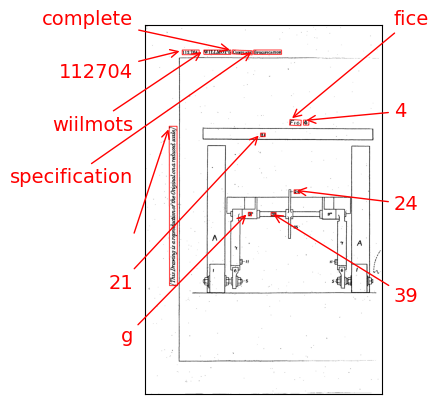

In [79]:
import matplotlib.pyplot as plt
import keras_ocr
pipeline = keras_ocr.pipeline.Pipeline()#read image from the an image path (a jpg/png file or an image url)
img = keras_ocr.tools.read(data_path+gb[0])# Prediction_groups is a list of (word, box) tuples
prediction_groups = pipeline.recognize([img])#print image with annotation and boxes
keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0])
#print list of string of the words found in the image
print([words for words, box in prediction_groups[0]])

Looking for /Users/mac/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/mac/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


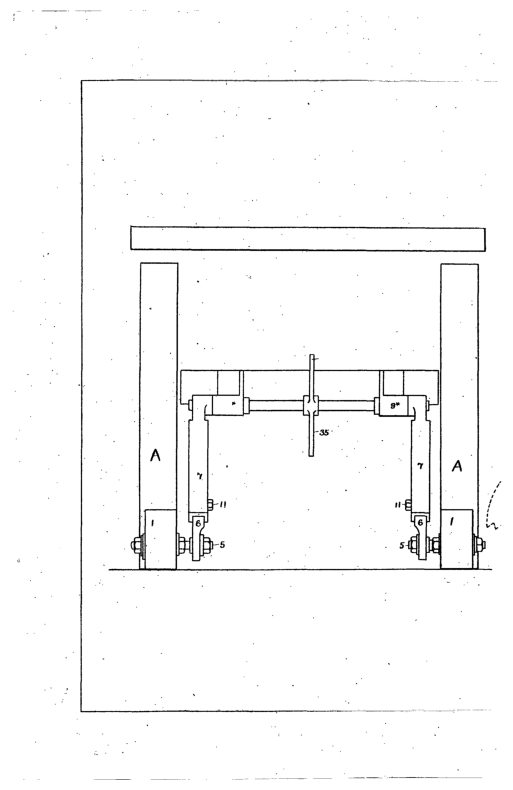

In [93]:
import keras_ocr
import cv2
import numpy as np

# Initialize keras OCR pipeline
pipeline = keras_ocr.pipeline.Pipeline()

# Function to fill text areas with white based on orientation
def fill_text_with_white(img_path, pipeline, padding=5):
    # Read image
    img = keras_ocr.tools.read(img_path)
    
    # Generate (word, box) tuples using OCR
    prediction_groups = pipeline.recognize([img])

    # Process each detected text box
    for text, box in prediction_groups[0]:
        # Convert box points to integer coordinates
        box = np.array(box).astype(int)
        
        # Determine the bounding box width and height
        x_min, x_max = min(box[:, 0]), max(box[:, 0])
        y_min, y_max = min(box[:, 1]), max(box[:, 1])
        width = x_max - x_min
        height = y_max - y_min

        # Check orientation based on width and height
        if width > height:
            # Horizontal text: apply padding only in x-direction
            x_min -= padding
            x_max += padding
        else:
            # Vertical text: apply padding only in y-direction
            y_min -= padding 
            y_max += padding + 20

        # Ensure coordinates are within image boundaries
        x_min = max(x_min, 0)
        x_max = min(x_max, img.shape[1])
        y_min = max(y_min, 0)
        y_max = min(y_max, img.shape[0])
        
        # Fill the bounding box area with white
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 255, 255), -1)

    return img

 # Adjust padding as needed


# Example usage with the provided image path
img_path = './dataset-dev/plates_png/GB.112704.A-011.png'
img_filled = fill_text_with_white(img_path, pipeline, padding=0)   # Increase padding if necessary
#save the output img
cv2.imwrite('output_ocr_GB.426870.A-007.png', img_filled)

# Display the result
plt.figure(figsize=(8, 10))
plt.imshow(img_filled)
plt.axis('off')
plt.show()



In [ ]:
def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 50, 150, apertureSize=5,L2gradient=False)
    kernel = np.ones((5, 5), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=3)

    return img_dilate



#first phase of segmentation to remove outer border present in images
def perfect_phase_1(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process(img_copy)

    contours, _ = cv2.findContours(processed_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 5000] #filter out small contours
    areas = []
    
    
    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        areas.append(w * h)
        

   
    #get the two biggest contours
    top2 = []
    for i in range(3):

        
        largest_index = areas.index(max(areas))
        largest_contour = filter_contours[largest_index]    
        
        top2.append(largest_contour)
        
        # Remove the selected contour from the lists
        del areas[largest_index]
        del filter_contours[largest_index]
    

    big = cv2.contourArea(top2[0])
    small = cv2.contourArea(top2[1]) + cv2.contourArea(top2[2])
    ratio = 0
    if cv2.contourArea(top2[1]) >= cv2.contourArea(top2[2]):
        ratio = cv2.contourArea(top2[2]) / cv2.contourArea(top2[1])
    else:
        ratio = cv2.contourArea(top2[1]) / cv2.contourArea(top2[2])
    
    #ratio = cv2.contourArea(top2[1]) / cv2.contourArea(top2[2])
    print(ratio)
    
    if small/big >0.9 and ratio >0.7:
        #print(cv2.contourArea(top2[1]))
        top2 = top2[1:]
    else:
        top2 = [top2[1]]
    
    
    #mask2 = np.zeros(img.shape).astype(np.uint8)
    #print("length" + str(len(top2)))
    color =[255,255,255]
    #cv2.fillPoly(mask2, top2, color)
    #res2 = cv2.bitwise_and(img_copy,mask2)
    res = []
    for ct in top2:
        new_image = np.zeros(img.shape).astype(np.uint8)
        #print(cv2.contourArea(ct), cv2.arcLength(ct,True))
        #print(cv2.isContourConvex(ct))
        #print(is_contour_closed(ct))
        #print the contour hierarchy near to the contour
        #x, y, w, h = cv2.boundingRect(ct)
        #rect = cv2.minAreaRect(ct)
        #box = cv2.boxPoints(rect)
        #box = np.int0(box)
        #hull = cv2.convexHull(ct)
        #cv2.drawContours(img_copy,[hull],0,(0,0,255),2)
        epsilon = 0.01 * cv2.arcLength(ct, True)
        approx = cv2.approxPolyDP(ct, epsilon, True)
        hull = cv2.convexHull(approx)
        #print(hull)
        #bbox = cv2.boundingRect(hull)
        #cv2.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 0, 255), 2)
        #print(approx)
        cv2.drawContours(img_copy, [hull], -1, (255, 0, 0), 4)
        
        
        cv2.fillPoly(new_image, pts =[hull], color=color)
        
        res.append(cv2.bitwise_and(img_copy,new_image))
        
        
    #cv2.fillPoly(mask2,top2, color=color)
    #res2 = cv2.bitwise_and(img_copy,mask2)
        #crop to hull bbox
        #print(bbox[0])
        #new_image = new_image[hull]     
        
        #cv2.drawContours(img_copy,[ct],0,(0,0,255),2)
        #x, y, w, h = cv2.boundingRect(ct)
        #cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 3)
        #cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return img_copy, top2, res
    
    
    
    #top2 = sorted(filter_contours, key=cv2.contourArea, reverse=True)[:3]
    '''
    for i, ct in enumerate(top3):
        x, y, w, h = cv2.boundingRect(ct)
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
        
        # Print the contour index and hierarchy near the contour
        index = contours.index(ct)
        h_info = hierarchy[0][index]  # hierarchy info for this contour
        text = f"{index} ({h_info[3]})"  # Display contour index and hierarchy level
        cv2.putText(img_copy, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 5)'''
        
    return img_copy, filter_contours
    '''  
    #print(len(areas))
    biggest = filter_contours[areas.index(max(areas))]
    #print(cv2.arcLength(biggest, True))
    #print(cv2.arcLength(biggest, False))
    
    epsilon = 0.02 * cv2.arcLength(biggest, False)
    approx = cv2.approxPolyDP(biggest, epsilon, False)
    #cv2.drawContours(img_copy, [approx], -1, (0, 0, 255), 2)
    #cv2.polylines(img_copy, [approx], isClosed=False, color=(0, 255, 0), thickness=2)
    hull =cv2.convexHull(biggest)
    #print(hull)
    cv2.drawContours(img_copy, [hull], -1, (0, 0, 255), 2)
    #k = cv2.isContourConvex(biggest)
    #print(k)
    #cv2.drawContours(img_copy,[biggest], -1, (0, 0, 255), 2)
    
    oldx, oldy, oldw, oldh = cv2.boundingRect(biggest)
    #paddingx= oldw* 1//30
    #paddingy= oldh* 1//20
    paddingx= 50
    paddingy= 50
    new_w = oldw - paddingx
    new_h = oldh - paddingy
    new_x = oldx + paddingx
    new_y = oldy + paddingy
    biggest = img_copy[new_y:oldy+new_h, new_x:oldx+new_w]
    # Create a white background image with the same size as the original
    white_background = np.ones((original_size[0], original_size[1], 3), dtype=np.uint8) * 255
    
    # Calculate the center position
    #center_x = (original_size[1] - biggest.shape[1]) // 2
    #center_y = (original_size[0] - biggest.shape[0]) // 2
    
    # Place the ROI in the center of the white background
    white_background[new_y:new_y+biggest.shape[0], new_x:new_x+biggest.shape[1]] = biggest
    #for ct in filter_contours:
        #x, y, w, h = cv2.boundingRect(ct)
        #cv2.rectangle(img_copy, (x+70, y+70), (x + w-50, y + h-50), (0, 0, 255), 2)
    return img_copy, filter_contours,hull'''
        

    
    




In [24]:

img,_ ,res= perfect_phase_1(data_path+'GB.359612.A-007.tif')
cv2.imshow("phase 1", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
for mask in res:
    cv2.imshow("phase 1", mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



0.7746038543897217


In [39]:
2195908.0+2116448.0

4312356.0

In [40]:
4312356.0/4602672.0

0.9369244647456956

In [18]:
img,_ ,res2,res= perfect_phase_1(data_path+'GB.401900.A-005.tif')
cv2.imshow("phase 1", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("phase 1", res)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("res", res2)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.7554188323127662


In [34]:
1816390.0/2674881.5

0.6790543805398482

In [35]:
1816390.0+191602.0

2007992.0

In [36]:
(1816390.0+191602.0)/2674881.5

0.7506844695736988

In [ ]:
GB.401900.A-005.tif
GB.359612.A-007

In [25]:

gb = []
data_path = './dataset-dev/plates/'
for i in os.listdir(data_path):
    if i.__contains__('GB'):
        
        gb.append(i)
gb

['GB.112704.A-011.tif',
 'GB.426870.A-007.tif',
 'GB.220420.A-010.tif',
 'GB.544722.A-035.tif',
 'GB.544722.A-021.tif',
 'GB.411884.A-027.tif',
 'GB.411884.A-033.tif',
 'GB.411963.A-008.tif',
 'GB.496119.A-009.tif',
 'GB.272628.A-015.tif',
 'GB.191506686.A-011.tif',
 'GB.545196.A-008.tif',
 'GB.125650.A-013.tif',
 'GB.152368.A-038.tif',
 'GB.191223716.A-012.tif',
 'GB.216640.A-004.tif',
 'GB.171939.A-005.tif',
 'GB.121298.A-007.tif',
 'GB.334584.A-060.tif',
 'GB.359612.A-007.tif',
 'GB.334584.A-048.tif',
 'GB.401900.A-005.tif',
 'GB.401900.A-004.tif',
 'GB.334584.A-049.tif',
 'GB.359612.A-006.tif',
 'GB.334584.A-061.tif',
 'GB.331224.A-006.tif',
 'GB.121298.A-012.tif',
 'GB.171939.A-010.tif',
 'GB.152368.A-011.tif',
 'GB.191417192.A-005.tif',
 'GB.216640.A-005.tif',
 'GB.191223716.A-013.tif',
 'GB.152368.A-039.tif',
 'GB.125650.A-012.tif',
 'GB.191506686.A-010.tif',
 'GB.545196.A-009.tif',
 'GB.272628.A-014.tif',
 'GB.374851.A-004.tif',
 'GB.411963.A-009.tif',
 'GB.411884.A-032.tif',
 

In [27]:
for i in gb[30:50]:
    
    img,_ ,res= perfect_phase_1(data_path+i)
    print(i)
    cv2.imshow("phase 1", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    for mask in res:
        cv2.imshow("phase 1", mask)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    #segmented, contours,_ = second_phase(figure,img_copy)
    #cv2.imshow("phase 2", segmented)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

0.5075648064531412
GB.191417192.A-005.tif
0.6313978785039187
GB.216640.A-005.tif
0.5496911693764106
GB.191223716.A-013.tif
0.38334067764804053
GB.152368.A-039.tif
0.24968878264899516
GB.125650.A-012.tif
0.5048247896734792
GB.191506686.A-010.tif
0.8547787469802832
GB.545196.A-009.tif
0.5958380803976135
GB.272628.A-014.tif
0.12800565076948492
GB.374851.A-004.tif
0.13616969594391753
GB.411963.A-009.tif
0.8928095516029295
GB.411884.A-032.tif
0.1556820159949737
GB.411884.A-026.tif
0.04923140685224803
GB.544722.A-034.tif
0.0103672629228987
GB.501859.A-004.tif
0.2994561406595174
GB.191020675.A-004.tif
0.15822513275889874
GB.112704.A-010.tif
0.07930501790533412
GB.112704.A-012.tif
0.06668674632098329
GB.403328.A-003.tif
0.5580126296135611
GB.180631.A-004.tif
0.9578951058046639
GB.561274.A-009.tif


In [256]:
def is_line_vertical_or_horizontal(pt1, pt2, tolerance=75):
    """
    Checks if the line between two points is approximately vertical or horizontal
    within a given tolerance.

    Parameters:
    - pt1: First point as (x, y).
    - pt2: Second point as (x, y).
    - tolerance: Maximum allowed deviation from vertical or horizontal.

    Returns:
    - True if the line is approximately vertical or horizontal, False otherwise.
    """
    # Calculate the differences
    dx = abs(pt1[0] - pt2[0])  # Difference in x-coordinates
    dy = abs(pt1[1] - pt2[1])  # Difference in y-coordinates

    # Check if it's approximately vertical or horizontal
    return dx <= tolerance or dy <= tolerance




def organize_and_filter_points(approx, image_width, image_height):
    """
    Organizes approx points into four buckets: top-left, top-right, bottom-right, bottom-left,
    and keeps only the point furthest from the origin for each bucket.

    Parameters:
    - approx: Approximated contour points (Nx1x2 array).
    - image_width: Width of the image for dividing points into buckets.
    - image_height: Height of the image for dividing points into buckets.

    Returns:
    - A list of exactly 4 points (one from each bucket).
    """
    buckets = {
        "top_left": [],
        "top_right": [],
        "bottom_left": [],
        "bottom_right": []
    }

    # Categorize points into buckets based on their positions
    for point in approx:
        x, y = point[0]
        if x < image_width // 3 and y < image_height // 3:
            buckets["top_left"].append((x, y))
        elif x >= image_width // 2 and y < image_height // 2:
            buckets["top_right"].append((x, y))
        elif x < image_width // 3 and y >= image_height // 2:
            buckets["bottom_left"].append((x, y))
        elif x >= image_width // 2 and y >= image_height // 2:
            buckets["bottom_right"].append((x, y))

    # Keep only the furthest point from the origin in each bucket
    filtered_points = []
    for bucket in buckets.values():
        if bucket:
            filtered_points.append(max(bucket, key=lambda p: p[0]**2 + p[1]**2))  # Furthest point from origin

    return np.array(filtered_points).reshape(-1, 1, 2)


def organize_and_sort_points_for_rectangle(approx):
    """
    Organizes and sorts points into a rectangular order: top-left, top-right, bottom-right, bottom-left.

    Parameters:
    - approx: Approximated contour points (Nx1x2 array).

    Returns:
    - A list of 4 points sorted in the order: top-left, top-right, bottom-right, bottom-left.
    """
    points = [point[0] for point in approx]  # Flatten the array into a list of points
    points = sorted(points, key=lambda p: (p[1], p[0]))  # Sort by y-coordinate, then x-coordinate

    # Separate top and bottom points
    top_points = sorted(points[:2], key=lambda p: p[0])  # Sort top points by x-coordinate
    bottom_points = sorted(points[2:], key=lambda p: p[0], reverse=True)  # Sort bottom points by x-coordinate

    # Order: top-left, top-right, bottom-right, bottom-left
    return np.array([top_points[0], top_points[1], bottom_points[0], bottom_points[1]]).reshape(-1, 1, 2)


# Updated perfect_phase_1 function
def perfect_phase_1(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    image_height, image_width = img.shape[:2]

    processed_img = process(img_copy)
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 5000]  # Filter out small contours
    areas = []

    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        areas.append(w * h)

    # Get the largest contour
    if filter_contours:
        largest_index = areas.index(max(areas))
        largest_contour = filter_contours[largest_index]

        epsilon = 0.01 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        print("Original approx points:", approx)

        # Organize points into buckets and filter
        filtered_approx = organize_and_filter_points(approx, image_width, image_height)
        
        filtered_approx = organize_and_sort_points_for_rectangle(filtered_approx)

        print("Filtered approx points:", filtered_approx)

        # Draw only vertical and horizontal lines
        for i in range(len(filtered_approx)):
            pt1 = tuple(filtered_approx[i][0])
            pt2 = tuple(filtered_approx[(i + 1) % len(filtered_approx)][0])  # Connect to the next point

            # Check if the line is vertical or horizontal
            if is_line_vertical_or_horizontal(pt1, pt2):
                cv2.line(img_copy, pt1, pt2, (0, 0, 255), 3)  # Draw line in blue

    return img_copy




for i in gb[0:10]: 
    img_copy = perfect_phase_1(data_path + i)
    print(i)
    cv2.imshow("phase 1", img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Original approx points: [[[ 303  300]]

 [[ 301 3003]]

 [[1736 3000]]

 [[ 306 2997]]

 [[ 308  306]]

 [[1862  304]]]
Filtered approx points: [[[ 308  306]]

 [[1862  304]]

 [[1736 3000]]

 [[ 301 3003]]]
GB.112704.A-011.tif
Original approx points: [[[ 361  270]]

 [[ 366 2981]]

 [[2002 2998]]

 [[1998  290]]]
Filtered approx points: [[[ 361  270]]

 [[1998  290]]

 [[2002 2998]]

 [[ 366 2981]]]
GB.426870.A-007.tif
Original approx points: [[[ 444  227]]

 [[ 429 2966]]

 [[2082 2983]]

 [[ 434 2960]]

 [[ 451  233]]

 [[2084  258]]

 [[2087 2748]]

 [[2091  250]]]
Filtered approx points: [[[ 451  233]]

 [[2091  250]]

 [[2082 2983]]

 [[ 429 2966]]]
GB.220420.A-010.tif
Original approx points: [[[ 633   76]]

 [[ 619 2218]]

 [[2261 2232]]

 [[2252   86]]]
Filtered approx points: [[[ 633   76]]

 [[2252   86]]

 [[2261 2232]]

 [[ 619 2218]]]
GB.544722.A-035.tif
Original approx points: [[[ 404  356]]

 [[ 395 3064]]

 [[2408 3087]]

 [[ 401 3058]]

 [[ 411  362]]

 [[2408  371]]]


IndexError: list index out of range

In [257]:
original,img_copy,_,black = extract_red(data_path+gb[0])
# Display the result
#make the figure bigger

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(original)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(black)
axes[1].axis('off')
axes[1].set_title('Red Color Extraction')
plt.show()

NameError: name 'extract_red' is not defined

In [122]:


# Function to fill text areas with white for segmentation
def fill_text_with_white(img_path, pipeline, padding=5):
    # Read image
    img = keras_ocr.tools.read(img_path)
    
    # Generate (word, box) tuples using OCR
    prediction_groups = pipeline.recognize([img])

    # Process each detected text box
    for text, box in prediction_groups[0]:
        # Convert box points to integer coordinates
        box = np.array(box).astype(int)
        
        # Determine the bounding box width and height
        x_min, x_max = min(box[:, 0]), max(box[:, 0])
        y_min, y_max = min(box[:, 1]), max(box[:, 1])
        width = x_max - x_min
        height = y_max - y_min

        # Check orientation based on width and height
        if width > height:
            # Horizontal text: apply padding only in x-direction
            x_min -= padding
            x_max += padding
        else:
            # Vertical text: apply padding only in y-direction
            y_min -= padding
            y_max += padding

        # Ensure coordinates are within image boundaries
        x_min = max(x_min, 0)
        x_max = min(x_max, img.shape[1])
        y_min = max(y_min, 0)
        y_max = min(y_max, img.shape[0])
        
        # Fill the bounding box area with white
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 255, 255), -1)

    return img

def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 1, apertureSize=5,L2gradient=True)
    kernel = np.ones((9, 9), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=4)
    img_res = cv2.erode(img_dilate, kernel, iterations=4)
    #img_close = morphology.binary_closing(img_canny,None)
    return img_res

def external_contour(img_path,pipeline):
    
    img = fill_text_with_white(img_path, pipeline, padding=20)   # Increase padding if necessary
    img_copy = np.copy(img)
    
    
    processed_img = process(img_copy)
    #cv2.imshow("processed", processed_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 5000] #filter out small contours
    areas = []
    original_size = img_copy.shape
    
    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        areas.append(w * h)

    #get the biggest contour
    biggest = filter_contours[areas.index(max(areas))]
    x, y, w, h = cv2.boundingRect(biggest)
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    #pad the bounding box
    paddingx= 50
    paddingy= 50
    new_w = w - paddingx
    new_h = h - paddingy
    new_x = x + paddingx
    new_y = y + paddingy
    
    cv2.rectangle(img_copy, (new_x, new_y), (new_x + new_w, new_y + new_h), (255, 0, 0), 2)
    return img_copy, biggest


    



In [123]:
import time
import keras_ocr
import cv2

# Initialize keras OCR pipeline
pipeline = keras_ocr.pipeline.Pipeline()

for i in gb[0:5]:
    # Start timing
    start_time = time.time()
    
    #Run the function for each image
    img_copy, _ = external_contour(data_path + i, pipeline)
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Print the file name and processing time
    print(f"Processed {i} in {elapsed_time:.2f} seconds")
    
    # Display the result
    cv2.imshow("phase 1", img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    



Looking for /Users/mac/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/mac/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
Processed GB.112704.A-011.tif in 11.94 seconds
2/2 [==============================] - 2s 489ms/step
Processed GB.426870.A-007.tif in 13.36 seconds
2/2 [==============================] - 2s 357ms/step
Processed GB.220420.A-010.tif in 12.53 seconds
2/2 [==============================] - 3s 920ms/step
Processed GB.544722.A-035.tif in 13.46 seconds
3/3 [==============================] - 5s 1s/step
Processed GB.544722.A-021.tif in 15.82 seconds


In [34]:
data_sam = pd.DataFrame(columns=['image_name','contours'])
for i in gb[10:20]:
    
    img_copy, _,figure = first_phase('./preprocessed_imgs/'+i)
    #print(k)
    #cv2.imshow("phase 1", figure)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    segmented, contours,_ = second_phase(figure,img_copy)
    cv2.imshow("phase 2", segmented)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    boxes = []
    for ct in contours:
        x, y, w, h = cv2.boundingRect(ct)
        boxes.append([x, y, x+w, y+h])
        
    
    data_sam = data_sam.append({'image_name':i,'contours':boxes},ignore_index=True)

data_sam.to_csv('data_for_sam.csv')
    

In [15]:


import ast

df = pd.read_csv('data_for_sam.csv')


# Let's modify the cleaning function to remove the trailing commas and parentheses correctly.

def clean_contours(contour_string):
    # Replace 'array' and unnecessary parts, clean the string properly by removing trailing commas and parentheses
    cleaned_string = contour_string.replace('array', '').replace('dtype=int32', '').replace('),),', ')]').replace(',)', ')')
    
    # Use ast.literal_eval to safely convert the string to a Python list
    list_of_lists = ast.literal_eval(cleaned_string)
    return list_of_lists

# Apply the updated cleaning function to the 'contours' column



df['contours'] = df['contours'].apply(clean_contours)
df.head(1)['contours'].values[0]


[([[417, 1074], [1947, 1074], [1947, 2412], [417, 2412]],),
 ([[509, 906], [1947, 906], [1947, 1040], [509, 1040]],),
 ([[1919, 352], [1948, 352], [1948, 787], [1919, 787]],),
 ([[595, 1873], [646, 1873], [646, 1936], [595, 1936]],),
 ([[1884, 1921], [1936, 1921], [1936, 1979], [1884, 1979]],),
 ([[1405, 851], [1464, 851], [1464, 902], [1405, 902]],)]

In [45]:
# Function to add padding to each corner of the box
def add_padding_to_box(box, padding_values):
    # Get the center of the original box
    center = np.mean(box, axis=0)
    
    # Initialize the new box with the same shape
    padded_box = np.copy(box).astype(np.float64)
    
    # Add padding to each corner
    for i in range(4):
        # Vector from center to the corner
        vector = padded_box[i] - center
        # Normalize the vector
        unit_vector = vector / np.linalg.norm(vector)
        # Apply padding along the direction of the vector
        padded_box[i] += padding_values[i] * unit_vector
        
    return np.int0(padded_box)

In [59]:
def process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 150)
    kernel = np.ones((3, 3), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=4)
    #erode

    return img_dilate

# First phase of segmentation to remove outer border present in images
def polygone_approx(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process(img_copy)
    contours, _ = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 3000]  # filter out small contours
    areas = []
    
    
    for ct in filter_contours:
        _, _, w, h = cv2.boundingRect(ct)
        areas.append(w * h)
    
    biggest = filter_contours[areas.index(max(areas))]
    
    
    # Approximate the contour to a polygon
    #epsilon = 0.05 * cv2.arcLength(biggest, False)
    #approx = cv2.approxPolyDP(biggest, epsilon, False)
    #print(approx)
    
    #make the y value of the top left point in the contour the same as the y value of the top right point of the contour
    #approx[0][0][1] = approx[1][0][1]
    #approx[0][0][0] = approx[1][0][0]
    
    hull = cv2.convexHull(biggest)
    
    cv2.drawContours(img, [hull], 0, (0, 0, 255), 2)
    #cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    print(box)
    
    #cv2.drawContours(img,[box],-1,(0,255,0),2) #green min rect
   
    padding_values = [-50.0, -50.0, -50.0, -50.0]

    # Add padding to the box
    padded_box = add_padding_to_box(box, padding_values)
    cv2.drawContours(img,[padded_box],0,(255,0,0),2) #blue box
    # Create a white background image with the same size as the original
    white_background = np.ones((img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255
    
    x, y, w, h = cv2.boundingRect(padded_box)
    roi = img[y:y+h, x:x+w]
    #put roi in the same position as original image in the white background
    white_background[y:y+h, x:x+w] = roi
    
    
    
    
    
    
    #biggest = img[y:y+h, x:x+w]
    #show content inside polygon
    cv2.drawContours(img, [hull], -1, (0, 0, 255), 2) # red hull
    #draw the polygone on image filled with white background the same size as the original image
    #cv2.fillPoly(mask, pts = [approx], color = 255)
    #masked_img = cv2.bitwise_and(img, mask)
    original_size = img.shape
    # Create a white background image with the same size as the original
    #white_background = np.ones((original_size[0], original_size[1], 3), dtype=np.uint8) * 255
    
    #white_background[y:y+h, x:x+w] = biggest

    
    
    # Fill the polygon on the mask
    #cv2.fillPoly(mask, pts = [approx], color = 255)
    #masked_img = cv2.bitwise_and(img, mask)
    
    

    return img, white_background,hull



In [60]:
for i in gb[25:30]:
    img_copy, new_image,figure = polygone_approx("./dataset-dev/plates/"+i)
    cv2.imshow("phase 1", img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

[[ 644 3188]
 [ 700  401]
 [2374  435]
 [2318 3222]]
[[ 339 2590]
 [ 346   49]
 [2267   54]
 [2260 2595]]
[[  67 2963]
 [ 139  229]
 [1781  272]
 [1709 3006]]
[[ 278  172]
 [2259  148]
 [2291 2736]
 [ 309 2760]]
[[ 970  236]
 [2408  229]
 [2421 2956]
 [ 983 2963]]


In [ ]:

import matplotlib.pyplot as plt

# Load the image
image_path = "./dataset-dev/plates/"+ gb[1]

# Function to compute intersection between two lines given in (rho, theta) form
def compute_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    # Coefficients for line 1
    A1 = np.cos(theta1)
    B1 = np.sin(theta1)
    # Coefficients for line 2
    A2 = np.cos(theta2)
    B2 = np.sin(theta2)
    # Calculate determinant
    determinant = A1 * B2 - A2 * B1
    if determinant == 0:
        return None  # Lines are parallel
    # Calculate intersection point
    x = (B2 * rho1 - B1 * rho2) / determinant
    y = (A1 * rho2 - A2 * rho1) / determinant
    return int(np.round(x)), int(np.round(y))


def hough_lines(image_path):
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection using Canny
    edges = cv2.Canny(gray, 0, 150)

# Apply Hough Line Transform
    lines = cv2.HoughLines(edges, 0.005, np.pi/180, 150)

# Separate lines into vertical and horizontal lines
    vertical_lines = []
    horizontal_lines = []

    if lines is not None:
        for line in lines:
           rho, theta = line[0]
           if abs(theta) < np.pi / 36 or abs(theta - np.pi) < np.pi / 36:  # Vertical lines
              vertical_lines.append((rho, theta))
           elif abs(theta - np.pi/2) < np.pi / 36:  # Horizontal lines
              horizontal_lines.append((rho, theta))

# Sort lines by their rho value (distance from origin)
    vertical_lines.sort(key=lambda x: x[0])
    horizontal_lines.sort(key=lambda x: x[0])

# Keep only the outermost vertical lines (leftmost and rightmost)
    selected_vertical_lines = [vertical_lines[0], vertical_lines[-1]]

    # Keep only the outermost horizontal lines (topmost and bottommost)
    selected_horizontal_lines = [horizontal_lines[0], horizontal_lines[-1]]



# Compute intersections between each pair of vertical and horizontal lines
    intersections = []
    for v_line in selected_vertical_lines:
        for h_line in selected_horizontal_lines:
            point = compute_intersection(v_line, h_line)
            if point is not None:
                intersections.append(point)

    # Draw only the segments between intersections
    clipped_image = np.copy(image)

    # Draw the top horizontal line segment
    cv2.line(clipped_image, intersections[0], intersections[1], (255, 0, 0), 2)

# Draw the bottom horizontal line segment
    cv2.line(clipped_image, intersections[2], intersections[3], (255, 0, 0), 2)

# Draw the left vertical line segment
    cv2.line(clipped_image, intersections[0], intersections[2], (255, 0, 0), 2)

# Draw the right vertical line segment
    cv2.line(clipped_image, intersections[1], intersections[3], (255, 0, 0), 2)
    
    return clipped_image

# Display the result
for i in gb[:10]:
    clipped_image = hough_lines("./dataset-dev/plates/"+i)
    cv2.imshow("Hough Lines", clipped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [43]:
gb = []
for i in os.listdir('./preprocessed_imgs/'):
    if i.__contains__('GB'):
        
        gb.append(i)
gb

['processed_GB.496204.A-005.png',
 'processed_GB.366323.A-006.png',
 'processed_GB.152368.A-028.png',
 'processed_GB.191223716.A-015.png',
 'processed_GB.152368.A-014.png',
 'processed_GB.548701.A-007.png',
 'processed_GB.128645.A-007.png',
 'processed_GB.174504.A-005.png',
 'processed_GB.334584.A-058.png',
 'processed_GB.516128.A-008.png',
 'processed_GB.544722.A-031.png',
 'processed_GB.544722.A-025.png',
 'processed_GB.287257.A-006.png',
 'processed_GB.400571.A-004.png',
 'processed_GB.505944.A-008.png',
 'processed_GB.180631.A-003.png',
 'processed_GB.294106.A-015.png',
 'processed_GB.202869.A-004.png',
 'processed_GB.357609.A-004.png',
 'processed_GB.229918.A-005.png',
 'processed_GB.191506686.A-016.png',
 'processed_GB.191424817.A-004.png',
 'processed_GB.208112.A-003.png',
 'processed_GB.411884.A-023.png',
 'processed_GB.191402180.A-005.png',
 'processed_GB.323831.A-005.png',
 'processed_GB.163636.A-008.png',
 'processed_GB.323831.A-004.png',
 'processed_GB.191402180.A-004.png',

In [44]:
import cv2
import numpy as np

def hough_outer_lines(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection using Canny
    edges = cv2.Canny(gray, 0, 150)

    # Apply Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)

    # Separate lines into vertical and horizontal lines
    vertical_lines = []
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            if abs(theta) < np.pi / 36 or abs(theta - np.pi) < np.pi / 36:  # Vertical lines
                vertical_lines.append((rho, theta))
            elif abs(theta - np.pi / 2) < np.pi / 36:  # Horizontal lines
                horizontal_lines.append((rho, theta))

    # Sort lines by their rho value (distance from origin)
    vertical_lines.sort(key=lambda x: x[0])
    horizontal_lines.sort(key=lambda x: x[0])

    # Keep only the outermost vertical lines (leftmost and rightmost)
    selected_vertical_lines = [vertical_lines[0], vertical_lines[-1]]

    # Keep only the outermost horizontal lines (topmost and bottommost)
    selected_horizontal_lines = [horizontal_lines[0], horizontal_lines[-1]]

    # Draw the selected lines
    result_image = np.copy(image)

    # Draw vertical lines
    for rho, theta in selected_vertical_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw horizontal lines
    for rho, theta in selected_horizontal_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return result_image

# Example usage
# Display the result
for i in gb[:5]:
    clipped_image = hough_lines("./preprocessed_imgs/"+i)
    cv2.imshow("Hough Lines", clipped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [15]:
# Directory paths
image_dir = "dataset-dev/plates_png"  # Replace with the directory where your images are stored
output_patch_dir = "output_patches"  # Where you want to save the image patches

# Create directory to save patches if it doesn't exist
if not os.path.exists(output_patch_dir):
    os.makedirs(output_patch_dir)

csv_file_path = 'model_data.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file_path)


images_names = set(data['image'])
images_names = list(images_names)

In [17]:
data.loc[data['image'] == images_names[1]]

,image,label
22,GB.411963.A-008.png,"(257, 497, 767, 1302)"
23,GB.411963.A-008.png,"(1526, 538, 483, 1308)"
24,GB.411963.A-008.png,"(1152, 530, 214, 1315)"
25,GB.411963.A-008.png,"(177, 2032, 251, 741)"


In [7]:

# Function to divide an image into 256x256 patches and transform the bounding box coordinates
def process_image(image_path, bboxes, patch_size=256):
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path).split('.')[0]
    original_height, original_width = image.shape[:2]

    patch_bboxes = []  # To store bounding boxes for each patch

    # Loop through image and divide it into 256x256 patches
    for patch_x in range(0, original_width, patch_size):
        for patch_y in range(0, original_height, patch_size):
            patch_x_max = patch_x + patch_size
            patch_y_max = patch_y + patch_size

            # Extract the patch
            patch = image[patch_y:patch_y_max, patch_x:patch_x_max]

            # Save the patch
            patch_filename = f"{image_name}_patch_{patch_x}_{patch_y}.png"
            patch_filepath = os.path.join(output_patch_dir, patch_filename)
            cv2.imwrite(patch_filepath, patch)

            # Check if any bounding boxes intersect with this patch
            for bbox in bboxes:
                x_min, y_min, x_max, y_max = bbox

                # Check if the bounding box intersects with this patch
                if (x_min < patch_x_max and x_max > patch_x and 
                    y_min < patch_y_max and y_max > patch_y):
                    
                    # Transform the bounding box coordinates relative to this patch
                    new_x_min = max(x_min - patch_x, 0)
                    new_y_min = max(y_min - patch_y, 0)
                    new_x_max = min(x_max - patch_x, patch_size)
                    new_y_max = min(y_max - patch_y, patch_size)

                    # Store the bounding box information with patch
                    patch_bboxes.append({
                        "patch_filename": patch_filename,
                        "bbox_in_patch": (new_x_min, new_y_min, new_x_max, new_y_max)
                    })

    return patch_bboxes



In [ ]:
# Iterate through the grouped data and process each image
all_patch_bboxes = []  # To store all transformed bounding boxes for all patches

for image_name in images_names:
    image_path = os.path.join(image_dir, image_name)
    df = data.loc[data['image'] == image_name]
    # Extract bounding boxes for the image and convert them to tuples
    bboxes = list(df['label'].apply(ast.literal_eval).values)

    
    
    
    #bboxes = [ast.literal_eval(bbox) for bbox in group['label'].values]

    # Process the image and get bounding boxes for each patch
    patch_bboxes = process_image(image_path, bboxes)
    
    # Collect the transformed bounding boxes
    all_patch_bboxes.extend(patch_bboxes)

# Convert the collected patch bounding box information to a DataFrame
transformed_bbox_df = pd.DataFrame(all_patch_bboxes)

# Save the transformed bounding boxes to a new CSV file
transformed_bbox_csv_path = "transformed_bboxes.csv"
transformed_bbox_df.to_csv(transformed_bbox_csv_path, index=False)

print(f"Transformed bounding boxes saved to: {transformed_bbox_csv_path}")

In [19]:
!pip install patchify

In [3]:
import numpy as np
import os
import cv2
import pandas as pd
from patchify import patchify  # For dividing images into patches
import ast

# Load the CSV file
csv_file_path = 'data_dl.csv'  # Replace with your actual CSV path
data = pd.read_csv(csv_file_path)

# Define the paths for your images (adjust as necessary)
image_dir = "dataset-dev/plates_png"  # Directory where your images are stored

# Desired patch size and step size (no overlap)
patch_size = 256
step = 256

# Function to convert bounding box string from CSV to tuple
def parse_bbox(bbox_string):
    return ast.literal_eval(bbox_string)

# Initialize arrays for image patches and corresponding transformed bounding boxes
all_img_patches = []
all_bbox_patches = []

# Loop over each image in the CSV
for image_name in data['image'].unique():
    image_path = os.path.join(image_dir, image_name)
    
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (2048, 2048))
    original_height, original_width = image.shape[:2]
    
    # Get bounding boxes for the current image
    bboxes = data[data['image'] == image_name]['label'].apply(parse_bbox).values
    
    # Patching the image
    patches_img = patchify(image, (patch_size, patch_size, 3), step=step)  # Patching the RGB image
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            # Extract the current patch
            single_patch_img = patches_img[i, j, 0, :, :, :]
            
            # Calculate the patch's top-left corner coordinates
            patch_x_min = j * patch_size
            patch_y_min = i * patch_size
            patch_x_max = patch_x_min + patch_size
            patch_y_max = patch_y_min + patch_size
            
            # Adjust bounding boxes for this patch
            patch_bboxes = []
            for bbox in bboxes:
                x_min, y_min, x_max, y_max = bbox
                
                # Check if the bounding box intersects with the current patch
                if (x_min <= patch_x_max and x_max >= patch_x_min and
                    y_min <= patch_y_max and y_max >= patch_y_min):
                    
                    # Transform the bounding box coordinates relative to the patch
                    new_x_min = max(x_min - patch_x_min, 0)
                    new_y_min = max(y_min - patch_y_min, 0)
                    new_x_max = min(x_max - patch_x_min, patch_size)
                    new_y_max = min(y_max - patch_y_min, patch_size)
                    
                    patch_bboxes.append([new_x_min, new_y_min, new_x_max, new_y_max])
            
            # Only append non-empty patches (patches with at least one bounding box)
            if len(patch_bboxes) > 0:
                all_img_patches.append(single_patch_img)
                all_bbox_patches.append(patch_bboxes)

# Convert lists to numpy arrays
images = np.array(all_img_patches)
bboxes = all_bbox_patches

# Let us print the shape of the resulting patch dataset
print(f"Image Patches Shape: {images.shape}")
#print(f"BBox Patches Shape: {bboxes.shape}")


Image Patches Shape: (3638, 256, 256, 3)


In [71]:
import matplotlib.patches as patches 

def display_patch_with_bbox(patch, bboxes, patch_idx):
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))

    # Draw bounding boxes
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title(f'Patch {patch_idx} with Bounding Boxes')
    plt.axis('off')
    plt.show()


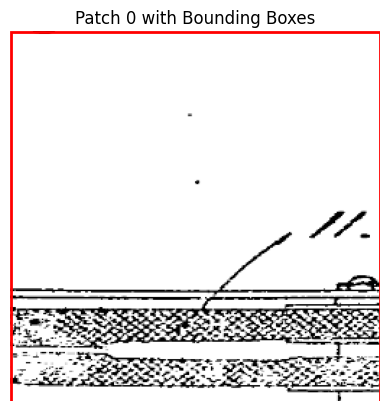

In [73]:
display_patch_with_bbox(images[250], bboxes[250], 0)

In [2]:
import torch
from transformers import SamProcessor


# SAMDataset adapted to bounding boxes without masks
class SAMDataset(torch.utils.data.Dataset):
    """
    This class creates a dataset that serves input images and bounding boxes for SAM.
    """
    def __init__(self, dataset, processor, resize_dims=(2048, 2048)):
        self.dataset = dataset
        self.processor = processor
        self.resize_dims = resize_dims

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Extract image and bounding box from the dataset
        item = self.dataset.iloc[idx]
        image = cv2.imread(os.path.join(image_dir, item['image']))  # Load the image from the dataset
        bbox = parse_bbox(item['label'])  # Bounding box coordinates

        # Resize image to target size (e.g., 1024x1024)
        image_resized = cv2.resize(image, self.resize_dims)

        # Prepare the bounding box prompt for SAM (formatted as list of list of list of float)
        input_boxes = [[[float(bbox[0]), float(bbox[1]), float(bbox[2]), float(bbox[3])]]]  # Properly format the bounding box

        # Prepare image and bounding box for the model
        inputs = self.processor(image_resized, input_boxes=input_boxes, return_tensors="pt")

        # Remove batch dimension (added by the processor by default)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Include bounding box as input_boxes
        inputs["input_boxes"] = torch.tensor(input_boxes, dtype=torch.float32)

        return inputs

# Initialize the processor for SAM
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Assuming your CSV file is loaded as a pandas dataframe
csv_file_path = 'data_dl.csv'  # Replace with the path to your CSV file
dataset = pd.read_csv(csv_file_path)

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# Example to test the dataset
example = train_dataset[0]
for k, v in example.items():
    print(k, v.shape)


2024-09-30 10:43:53.126965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 1, 4])


In [75]:
from torch.utils.data import DataLoader

# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

# Example to fetch a batch
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)


pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 1, 4])


In [76]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [68]:

from torch.optim import Adam
#import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss this is for the masks, since we are using bounding boxes 
#seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [67]:
def compute_iou_loss(pred_boxes, gt_boxes):
    """
    Compute IoU loss between predicted and ground-truth bounding boxes.
    
    Args:
    - pred_boxes (torch.Tensor): Predicted bounding boxes of shape (N, 4).
    - gt_boxes (torch.Tensor): Ground-truth bounding boxes of shape (N, 4).
    
    Returns:
    - loss (torch.Tensor): IoU loss.
    """
    # Intersection box
    inter_x_min = torch.max(pred_boxes[:, 0], gt_boxes[:, 0])
    inter_y_min = torch.max(pred_boxes[:, 1], gt_boxes[:, 1])
    inter_x_max = torch.min(pred_boxes[:, 2], gt_boxes[:, 2])
    inter_y_max = torch.min(pred_boxes[:, 3], gt_boxes[:, 3])
    
    inter_area = torch.clamp(inter_x_max - inter_x_min, min=0) * torch.clamp(inter_y_max - inter_y_min, min=0)

    # Union box
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    
    union_area = pred_area + gt_area - inter_area

    # IoU
    iou = inter_area / torch.clamp(union_area, min=1e-6)
    
    # IoU loss (1 - IoU)
    return 1 - iou



In [ ]:
num_epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        predicted_boxes = outputs.pred_boxes.squeeze(1)
        ground_truth_boxes = batch["input_boxes"].squeeze(1).to(device)

        # Compute IoU loss
        loss = compute_iou_loss(predicted_boxes, ground_truth_boxes)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


In [26]:
def process_extern(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 0, 250)
    kernel = np.ones((5, 5), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=1)
    return img_dilate


def extern(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process_extern(img_copy)
    #cv2.imshow("processed_img", processed_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 3000] #filter out small contours
    #SORT CONTOURS by area
    areas = []
    original_size = img_copy.shape
    #print(len(filter_contours))
    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        areas.append(w*h)
        
    #print(len(areas))
    biggest = filter_contours[areas.index(max(areas))]
    #print(cv2.arcLength(biggest, True))
    #print(cv2.arcLength(biggest, False))
    
    epsilon = 0.002 * cv2.arcLength(biggest, False)
    approx = cv2.approxPolyDP(biggest, epsilon, True)
    #cv2.drawContours(img_copy, [approx], -1, (0, 0, 255), 2)
    #cv2.polylines(img_copy, [approx], isClosed=False, color=(0, 255, 0), thickness=2)
    hull =cv2.convexHull(approx)
    print(hull)
    #print(hull)
    cv2.drawContours(img_copy, [hull], -1, (0, 0, 255), 2)
    return img_copy,filter_contours,hull

In [31]:
data_path = 'preprocessed_imgs/'
for i in gb[0:20]:
    img, contours,_ = extern(data_path+i)
    cv2.imshow("phase 1", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


[[[2246  390]]

 [[2248 2378]]

 [[ 213  406]]]
[[[2184 3154]]

 [[1787 3188]]

 [[ 194 3178]]

 [[ 193  493]]

 [[2077  442]]

 [[2200  470]]]
[[[2370 3270]]

 [[ 608 3296]]

 [[ 580  801]]

 [[2369  771]]]
[[[1998  995]]

 [[1990 2416]]

 [[  86 2419]]

 [[  97  994]]]
[[[2406 1940]]

 [[2407 2083]]

 [[2407 2429]]

 [[2189 2484]]

 [[1825 2552]]

 [[1467 2508]]

 [[1351 2351]]

 [[1172 2021]]

 [[1165 1913]]]
[[[2322 2238]]

 [[ 184 2241]]

 [[ 185  638]]

 [[ 186  606]]

 [[2326  625]]]
[[[2005 2357]]

 [[  96 2380]]

 [[  81  937]]

 [[1987  918]]]
[[[2297  511]]

 [[2263 3223]]

 [[2211 3236]]

 [[1984 3259]]

 [[ 225 3214]]

 [[ 227  500]]]
[[[2197 3082]]

 [[ 286 3107]]

 [[ 268  558]]

 [[2182  536]]]
[[[2320  453]]

 [[2315 3155]]

 [[ 221 3154]]

 [[ 223  451]]]
[[[2232 3173]]

 [[ 214 3201]]

 [[ 213  499]]

 [[2215  459]]]
[[[2221 3114]]

 [[ 214 3130]]

 [[ 213  443]]

 [[2214  421]]]
[[[3411  464]]

 [[3400 2333]]

 [[3135 2354]]

 [[ 893 2343]]

 [[ 911  470]]

 [[3317 